# Phase II Project Technical Notebook

Authors: Kyle Dufrane and Kevin McDonough

In [75]:
# Imports 
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
%load_ext autotime
from folium.plugins import StripePattern
import geopandas as gpd

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


## Business Understanding 

Our stakeholder is a family that is moving to the Seattle area. They would like to buy a house that maximizes square footage, and they are looking for a house that they deem to be under-valued. There are 3 children in the family, so they would like to find a house with at least 4 bedrooms. 

## Data Understanding

In [76]:
df = pd.read_csv('data/KC_with_hoods', index_col=0)

In [77]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...        1180            0.0   
1      7242     2.0         0.0   0.0  ...        2170          400.0   
2     10000     1.0         0.0   0.0  ...         770            0.0   
3      5000     1.0         0.0   0.0  ...        1050          910.0   
4      8080     1.0         0.0   0.0  ...        1680            0.0   

   yr_built yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955          0.0    98178  47.5112 -122.257           1340   
1      1951       1991.0    98125  47.7210 -122.319           1690   
2      1933          NaN    98028  47.7379 -122.233           2720   
3      1965          0.0    98136  47.5208 -122.393           1360   
4      1987          0.0    98074  47.6168 -122.045           1800   

   sqft_lot15   Neighborhood  
0        5650  Rainier Beach  
1        7639      Northgate  
2        8062        Kenmore  
3        5000     Fauntleroy  
4        7503      Sammamish  

[5 rows x 22 columns]

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. In the datframe above, we used an API that allowed us to reverse geocode the latitude and longitude into neighborhoods. The code for this can be found in our individual technical notebooks -- it is a lot of code so we thought we'd leave it out of this notebook. The process of reverse geocoding all 21,597 entries in our DataFrame took ~5 hours. Below is a description of what head column represents: 

**id** - unique identifier for a house  <br>
**date** - house was sold  <br>
**price** -  is prediction target  <br>
**bedrooms** -  of Bedrooms/House  <br>
**bathrooms** -  of bathrooms/bedrooms  <br>
**sqft_living** -  footage of the home  <br>
**sqft_lot** -  footage of the lot  <br>
**floors** -  floors (levels) in house  <br>
**waterfront** - House which has a view to a waterfront  <br>
**view** - Has been viewed  <br>
**condition** - How good the condition is ( Overall )  <br>
**grade** - overall grade given to the housing unit, based on King County grading system  <br>
**sqft_above** - square footage of house apart from basement  <br>
**sqft_basement** - square footage of the basement  <br>
**yr_built** - Built Year  <br>
**yr_renovated** - Year when house was renovated  <br>
**zipcode** - zip  <br>
**lat** - Latitude coordinate  <br>
**long** - Longitude coordinate  <br>
**sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors  <br>
**sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors  <br>
**Neighborhood** - geopy reverse geocoded neighborhoods using the lat and long columns

## Data Cleaning 

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Inspecting this, we can see that "date" and "sqft_basement" are currently objects, so we will have to convert them to usable formats before we model. Let's start by converting date two two new categories month and year:

In [79]:
df['Yr_sold'] = df['date'].apply(lambda x: x[-4:])
df['Mo_sold'] = df['date'].apply(lambda x: x[0:2])
df['Mo_sold'] = df['Mo_sold'].apply(lambda x: x[0:1] if "/" in x else x)

In [80]:
df['Mo_sold'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: Mo_sold, dtype: int64

Looks like the least number of homes were sold in January. Because this is a categorical variable, we will have to create dummies to incorporate this into the model. Knowing that January has the least number of values, that could be a good column to drop.

In [81]:
df['Yr_sold'].value_counts()

2014    14622
2015     6975
Name: Yr_sold, dtype: int64

This dataset only spans 2014 to 2015 so it makes sense that these are the two values. Because there are only two values, we can use OrdinalEncoder to turn this into a binary variable.

In [82]:
from sklearn.preprocessing import OrdinalEncoder
year = df[['Yr_sold']]
encoder_year = OrdinalEncoder()
encoder_year.fit(year)
year_encoded = encoder_year.transform(year)
year_encoded = year_encoded.flatten()
df['Yr_sold'] = year_encoded

Now that we have transformed the dates, we can drop the original date column 

In [83]:
df = df.drop('date', axis=1)

Now let's check out why the sqft_basement category was an object rather than an integer or float

In [84]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
176.0         1
1024.0        1
2350.0        1
915.0         1
768.0         1
Name: sqft_basement, Length: 304, dtype: int64

Looks like there is a "?" for missing values. This doesn't mean that there is no basement because there are 12,826 entries that have 0 for basement square footage. Let's substitute the median square footage in for all entries with a "?" (the median will be 0). 

In [85]:
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: np.nan if "?" in x else x)

In [86]:
basement = df[['sqft_basement']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(basement)
basement_imputed = imputer.transform(basement)
basement_imputed
df['sqft_basement'] = basement_imputed

In [87]:
df.isna().sum()

id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
Neighborhood        0
Yr_sold             0
Mo_sold             0
dtype: int64

Looks like the waterfront, view and yr_renovated columns are missing data, we will have to address this if we want to use these variables in our model. Let's start by checking out waterfront:

In [88]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

Looks like it is a binary variable that contains a 1 if the property is on the waterfront and 0 if it is not. We believe the best strategy is to replace the missing values with the median(0). 

In [89]:
waterfront = df[['waterfront']]
imputer = SimpleImputer(strategy='median')
imputer.fit(waterfront)
waterfront_imputed = imputer.transform(waterfront)
df['waterfront'] = waterfront_imputed

Now that we have cleaned up waterfront let's examine the view column

In [90]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

The view column tells us whether a property has been viewed. The numbers here must represent the amount of times it's been viewed. It looks like the vast majority have not been viewed so, once again, we will replace the missing values with the median (0).

In [91]:
view = df[['view']]
imputer = SimpleImputer(strategy='median')
imputer.fit(view)
view_imputed = imputer.transform(view)
df['view'] = view_imputed

In [92]:
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.264306
view             0.393497
condition        0.036056
grade            0.667951
sqft_above       0.605368
sqft_basement    0.321108
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Yr_sold          0.003727
Name: price, dtype: float64

In [93]:
df['view'].value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

The last column containing missing values is the Yr_renovated column, let's take a look: 

In [94]:
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

It appears that a value of 0 in this column signifies that the home has not been renovated. It is unclear whether the missing values mean that the home has not been renovated. To deal with this, let's use a function to bin the values. 

In [95]:
def bin_year(value):
    if value == 0:
        return "No remodel"
    elif value > 0 and value < 1980:
        return "pre-1980"
    elif value >= 1980 and value < 1990:
        return "1980s"
    elif value >= 1990 and value < 2000:
        return "1990s"
    elif value >= 2000 and value < 2010:
        return "2000s"
    elif value >= 2010 and value <= 2015:
        return "2010s"
    else:
        return "Unknown"

In [96]:
bin_year(2011)

'2010s'

In [97]:
df['yr_renovated'] = df['yr_renovated'].apply(bin_year)

In [98]:
df['yr_renovated'].value_counts()

No remodel    17011
Unknown        3842
2000s           229
2010s           150
1990s           143
1980s           124
pre-1980         98
Name: yr_renovated, dtype: int64

Because the variable is binned, we can create a dummies later if we want to incorporate it into our model. We have now dealt with all missing values and transformed the datatypes that were classified incorrectly so we can begin modeling 

## Business Understanding 

Our stakeholder is interested in purchasing a house at a reasonable cost. In order to aid them in this endeavor, we need to build a model that can accurately predict price. Additionally, we need to identify which features influence price the most. Lastly, we need to quantify the impact each feature has so that they can determine whether or not it is worth paying for. 

### Identifying Extraneous Features

Let's start by identifying which variables have the least impact on price. 

In [99]:
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.264306
view             0.393497
condition        0.036056
grade            0.667951
sqft_above       0.605368
sqft_basement    0.321108
yr_built         0.053953
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Yr_sold          0.003727
Name: price, dtype: float64

The id column is just the identifier used for each house so we should drop that for modeling purposes. we will also drop latitude and longitude -- we will create dummies for neighborhood and zipcode later that will do a better job of quantifying the effect location has on price than latitude and longitude do. 

In [100]:
relevant_cols = ['price', 'bedrooms','bathrooms','sqft_living','sqft_lot'\
                 ,'floors','waterfront','view','condition','grade','sqft_above', 'sqft_basement',\
                 'yr_built','yr_renovated','zipcode','sqft_living15','sqft_lot15','Neighborhood', 'Yr_sold', 'Mo_sold']

In [101]:
df = df[relevant_cols]

### First Simple Model

For our first simple model lets use square feet to predict price. We are choosing square feet because, based on the correlation output, it is the variable with the largest impact on price. Additionally, our stakeholder indicated they would like to have a house with high square-footage

In [102]:
df

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221900.0         3       1.00         1180      5650     1.0   
1      538000.0         3       2.25         2570      7242     2.0   
2      180000.0         2       1.00          770     10000     1.0   
3      604000.0         4       3.00         1960      5000     1.0   
4      510000.0         3       2.00         1680      8080     1.0   
...         ...       ...        ...          ...       ...     ...   
21592  360000.0         3       2.50         1530      1131     3.0   
21593  400000.0         4       2.50         2310      5813     2.0   
21594  402101.0         2       0.75         1020      1350     2.0   
21595  400000.0         3       2.50         1600      2388     2.0   
21596  325000.0         2       0.75         1020      1076     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
0             0.0   0.0          3      7        1180            0.0   
1             0.0   0.0          3      7        2170          400.0   
2             0.0   0.0          3      6         770            0.0   
3             0.0   0.0          5      7        1050          910.0   
4             0.0   0.0          3      8        1680            0.0   
...           ...   ...        ...    ...         ...            ...   
21592         0.0   0.0          3      8        1530            0.0   
21593         0.0   0.0          3      8        2310            0.0   
21594         0.0   0.0          3      7        1020            0.0   
21595         0.0   0.0          3      8        1600            0.0   
21596         0.0   0.0          3      7        1020            0.0   

       yr_built yr_renovated  zipcode  sqft_living15  sqft_lot15  \
0          1955   No remodel    98178           1340        5650   
1          1951        1990s    98125           1690        7639   
2          1933      Unknown    98028           2720        8062   
3          1965   No remodel    98136           1360        5000   
4          1987   No remodel    98074           1800        7503   
...         ...          ...      ...            ...         ...   
21592      2009   No remodel    98103           1530        1509   
21593      2014   No remodel    98146           1830        7200   
21594      2009   No remodel    98144           1020        2007   
21595      2004   No remodel    98027           1410        1287   
21596      2008   No remodel    98144           1020        1357   

         Neighborhood  Yr_sold Mo_sold  
0       Rainier Beach      0.0      10  
1           Northgate      0.0      12  
2             Kenmore      1.0       2  
3          Fauntleroy      0.0      12  
4           Sammamish      1.0       2  
...               ...      ...     ...  
21592  Licton Springs      0.0       5  
21593    White Center      1.0       2  
21594          Leschi      0.0       6  
21595        Issaquah      1.0       1  
21596          Leschi      0.0      10  

[21597 rows x 20 columns]

In [103]:
formula = 'price ~ sqft_living'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:07:12   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Although the model doesn't do a great job of explaining the variance (r-squared = .493), the t value and associated p value tell us that sqft_living definitely impacts price. The coefficient tells us that every increase in square footage increases price by ~280. Now the stakeholder can roughly estimate the cost of an increase in square footage

### Multiple Regression Model

Next let's construct a multiple regression model to evaluate which columns to keep and get rid of. In order to do this, we need to create a df that doesn't contain any columns with categoricals (we will turn those into dummies later.)

In [104]:
categoricals = ['yr_renovated', 'zipcode', 'Neighborhood', 'Mo_sold']
df_no_cats = df.drop(categoricals, axis=1)

In [105]:
multiple_formula = 'price ~' + '+'.join(df_no_cats.columns[1:])
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2736.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:07:14   Log-Likelihood:            -2.9589e+05
No. Observations:               21597   AIC:                         5.918e+05
Df Residuals:                   21581   BIC:                         5.919e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.334e+06   1.31e+05     48.427      0.000    6.08e+06    6.59e+06
bedrooms      -3.984e+04   2031.935    -19.605      0.000   -4.38e+04   -3.59e+04
bathrooms      4.765e+04   3471.383     13.727      0.000    4.08e+04    5.45e+04
sqft_living     112.9512     19.369      5.832      0.000      74.987     150.915
sqft_lot         -0.0073      0.051     -0.143      0.886      -0.108       0.093
floors         2.806e+04   3782.065      7.420      0.000    2.06e+04    3.55e+04
waterfront     6.167e+05   1.94e+04     31.754      0.000    5.79e+05    6.55e+05
view           4.357e+04   2249.579     19.368      0.000    3.92e+04     4.8e+04
condition      2.001e+04   2463.351      8.123      0.000    1.52e+04    2.48e+04
grade          1.212e+05   2253.765     53.775      0.000    1.17e+05    1.26e+05
sqft_above       47.5625     19.340      2.459      0.014       9.655      85.471
sqft_basement    54.8696     19.194      2.859      0.004      17.248      92.491
yr_built      -3652.0764     67.274    -54.287      0.000   -3783.938   -3520.215
sqft_living15    24.2326      3.596      6.740      0.000      17.185      31.280
sqft_lot15       -0.5526      0.078     -7.057      0.000      -0.706      -0.399
Yr_sold         2.68e+04   3146.916      8.517      0.000    2.06e+04     3.3e+04
==============================================================================
Omnibus:                    16333.506   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1192294.244
Skew:                           3.035   Prob(JB):                         0.00
Kurtosis:                      38.890   Cond. No.                     4.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model does a much better job of explaining the variance. Also, the sqft_lot P value is very high so we will get rid of that variable moving forward. Let's next look at multicollinearity to identify if this is an issue:

In [106]:
correlation_matrix = df_no_cats.corr()

In [107]:
df_corr=correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(10)

cc
pairs                                 
(sqft_above, sqft_living)     0.876448
(sqft_living, grade)          0.762779
(sqft_living15, sqft_living)  0.756402
(grade, sqft_above)           0.756073
(bathrooms, sqft_living)      0.755758
(sqft_living15, sqft_above)   0.731767
(sqft_lot15, sqft_lot)        0.718204
(grade, sqft_living15)        0.713867
(price, sqft_living)          0.701917
(sqft_above, bathrooms)       0.686668

square footage above is very correlated with total square footage. Because square footage above has a higher p-value in the summary above, as well as a lower overall correlation with price, we will remove this column going forward. 

In [108]:
df = df.drop('sqft_lot', axis=1)
df = df.drop('sqft_above', axis=1)

We should also quickly check to the see if the variables in the multiple model approximate a normal distribution

In [109]:
# for column in df_no_cats:
#     df_no_cats[column].plot.hist(density=True, label = column+' histogram')
#     df_no_cats[column].plot.kde(label =column+' kde')
#     plt.legend()
#     plt.show()

Besides the variables that are binary or discreet, it looks like they are fairly normally distributed and don't need major transformations

#### Feature Transformation

Next, let's see if any of the interactions between variables is a good predictor of price

In [110]:
pf = PolynomialFeatures(degree=2)

X = df_no_cats


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
corr_df[corr_df['x0'] > .75]['x0']

x0        1.000000
x0^2      0.839331
x0 x1     0.937872
x0 x2     0.917409
x0 x3     0.900728
x0 x5     0.908166
x0 x8     0.945235
x0 x9     0.982774
x0 x10    0.890669
x0 x12    0.999584
x0 x13    0.938750
x3 x9     0.756248
Name: x0, dtype: float64

Unsurprisingly the interactions that have the highest correlation with price ('x0') are mostly price multiplied by a different category. However, x3 * x9 has a high correlation with price as well. Examining pdf, we can see that this is square footage multiplied by grade. We should add this interaction into our model to see the effect on r-squared

In [111]:
df_no_cats = df.drop(categoricals, axis=1)

In [112]:
df_no_cats['sqft_grade'] = df_no_cats['sqft_living'] * df_no_cats['grade']

In [113]:
multiple_formula = 'price ~' + '+'.join(df_no_cats.columns[1:])
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     3500.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:07:19   Log-Likelihood:            -2.9459e+05
No. Observations:               21597   AIC:                         5.892e+05
Df Residuals:                   21582   BIC:                         5.893e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.224e+06   1.23e+05     50.544      0.000    5.98e+06    6.47e+06
bedrooms      -1.382e+04   1976.445     -6.991      0.000   -1.77e+04   -9944.022
bathrooms      5.468e+04   3268.969     16.726      0.000    4.83e+04    6.11e+04
sqft_living    -302.3840      9.531    -31.727      0.000    -321.065    -283.703
floors         5.435e+04   3574.951     15.203      0.000    4.73e+04    6.14e+04
waterfront     5.868e+05   1.83e+04     32.073      0.000    5.51e+05    6.23e+05
view           3.742e+04   2119.069     17.657      0.000    3.33e+04    4.16e+04
condition      2.737e+04   2323.479     11.781      0.000    2.28e+04    3.19e+04
grade          1.151e+04   2979.991      3.863      0.000    5669.547    1.74e+04
sqft_basement    48.3058      4.300     11.235      0.000      39.878      56.733
yr_built      -3197.2676     63.912    -50.026      0.000   -3322.540   -3071.995
sqft_living15    37.4724      3.384     11.073      0.000      30.839      44.106
sqft_lot15       -0.5539      0.053    -10.530      0.000      -0.657      -0.451
Yr_sold        2.548e+04   2963.850      8.598      0.000    1.97e+04    3.13e+04
sqft_grade       48.5408      0.925     52.477      0.000      46.728      50.354
==============================================================================
Omnibus:                    10318.716   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           298987.257
Skew:                           1.711   Prob(JB):                         0.00
Kurtosis:                      20.904   Cond. No.                     2.85e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After dropping the two columns we mentioned earlier and adding our new column our r-squared value went up to .694. Looking at the summary, we can be confident that this new column has a relationship with price between our t value is very high (52.477). Let's apply this feature to the main df to use in models going forward

In [114]:
df['sqft_grade'] = df['sqft_living'] * df['grade']

#### Creating Dummy Variables for Categorical Data

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  float64
 6   view           21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_basement  21597 non-null  float64
 10  yr_built       21597 non-null  int64  
 11  yr_renovated   21597 non-null  object 
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
 15  Neighborhood   21597 non-null  object 
 16  Yr_sold        21597 non-null  float64
 17  Mo_sold        21597 non-null  object 
 18  sqft_g

There are a couple categories that we need to create dummy variables for so that we can incorporate them into the model. These categories are yr_renovated, zipcode, Neighborhood and Mo_sold. Let's test them one by one to see if adding them into the model improves our r-squared value 

In [116]:
X = df.copy()

from sklearn.preprocessing import OneHotEncoder
month = X[['Mo_sold']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(month)
ohe.categories_
month_encoded = ohe.transform(month)

month_encoded = pd.DataFrame(

    month_encoded,

    columns=ohe.categories_[0],
 
    index=X.index
)

month_encoded = month_encoded.drop('1', axis=1)
month_encoded

10   11   12    2    3    4    5    6    7    8    9
0      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3      0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
21592  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
21593  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
21594  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
21595  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
21596  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[21597 rows x 11 columns]

We now have the months encoded in a pandas dataframe. We decided to drop january because, as we saw earlier, it has the least amount of values. let's run a regression to see if month has an impact on price

In [117]:
from sklearn.linear_model import LinearRegression
y = df_no_cats['price']
X = df_no_cats.drop('price', axis=1)

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.694251316412003

In [118]:
X = pd.concat([X.reset_index(drop=True), month_encoded.reset_index(drop=True)], axis=1)

In [119]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.6950595028915841

Looks like it didn't have a big impact on the model (r-squared of .695 versus .694, but let's keep it in there because it at least bumped it up. big. Next lets try zipcode.

In [120]:
df['zipcode'].value_counts().index[69]

98039

In [121]:
zipcode = df[['zipcode']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(zipcode)
ohe.categories_
zip_encoded = ohe.transform(zipcode)

zip_encoded = pd.DataFrame(

    zip_encoded,
  
    columns=ohe.categories_[0],
   
    index=df.index
)

zip_encoded = zip_encoded.drop(98039, axis=1)

In [122]:
X = pd.concat([X.reset_index(drop=True), zip_encoded.reset_index(drop=True)], axis=1)

In [123]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.8410224735278342

Incorporating zipcodes into the model increased our r-squared from .695 to .841. Next we will try incorporating our binned renovation year column

In [124]:
renovation = df[['yr_renovated']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(renovation)
ohe.categories_
renovation_encoded = ohe.transform(renovation)

renovation_encoded = pd.DataFrame(

    renovation_encoded,
  
    columns=ohe.categories_[0],
   
    index=df.index
)

renovation_encoded = renovation_encoded.drop('Unknown', axis=1)

In [125]:
X = pd.concat([X.reset_index(drop=True), renovation_encoded.reset_index(drop=True)], axis=1)

In [126]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.8425284975412348

The binned renovation year did not have nearly as big an impact as the zipcodes did, but we will still keep them in the model because they nudged the r-squared up from .8410 to .8425. The last categorical variable we need to incorporate is neighborhood. This cateogry has some overlap with zipcode but it adds a little more specificity

In [127]:
hood = df[['Neighborhood']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(hood)
ohe.categories_
hood_encoded = ohe.transform(hood)

hood_encoded = pd.DataFrame(

    hood_encoded,
  
    columns=ohe.categories_[0],
   
    index=df.index
)


hood_encoded
hood_encoded = hood_encoded.drop('Other', axis=1)

In [128]:
X = pd.concat([X.reset_index(drop=True), hood_encoded.reset_index(drop=True)], axis=1)

In [129]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.8580505189373653

We now have a model that does a good job of predicting the variance in the dataset (r squared =.86). Next we will have to view the residuals to make sure we are not violating any modeling assumptions. Let's add a new column to our original dataframe that has our prediction, as well as a column for the residual

In [156]:
df['prediction'] = model.predict(X)
df['residual'] = df['price'] - df['prediction']

#### Evaluating Residuals

In [130]:
residual = y - model.predict(X)

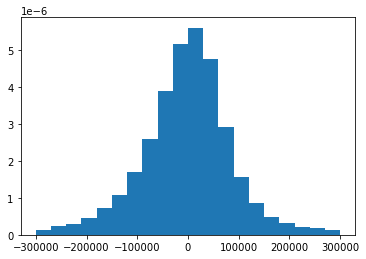

In [131]:
fig, ax = plt.subplots()
ax.hist(residual, bins=20, density=True, range =[-300000,300000]);
plt.savefig('Visualizations/residuals_hist')

Based on the plot above, it looks like the residuals are normally distributed around 0, this is a good sign 


/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


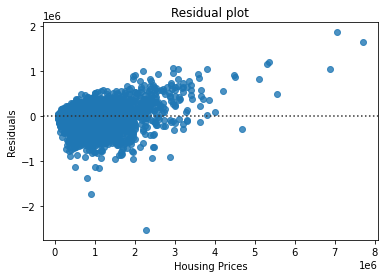

In [132]:
sns.residplot(y, residual)
    
plt.xlabel("Housing Prices")
plt.ylabel("Residuals")
plt.title('Residual plot');
plt.savefig('Visualizations/residuals')

There appears to be some slight heteroskedasticity in the plot above, due to some outliers in the upper right portion of the graph.

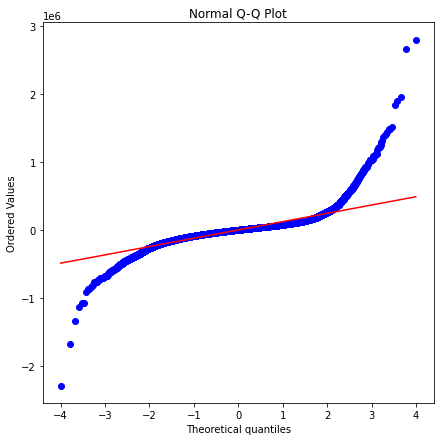

In [133]:
plt.figure(figsize=(7,7))
stats.probplot(residual, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.savefig('Visualizations/residuals')

Let's also run a quick train/test split to make sure we are not overfitting out data

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
print(len(X_train), len(X_test), len(y_train), len(y_test))

lr = LinearRegression()
lr.fit(X_train, y_train)
train_score = round(lr.score(X_train, y_train),3)
test_score = round(lr.score(X_test, y_test), 3)

print("train r-squared: {}".format(train_score) + " test r-squared: {}".format(test_score))

15117 6480 15117 6480
train r-squared: 0.858 test r-squared: 0.851


#### Model implications for our stakeholder

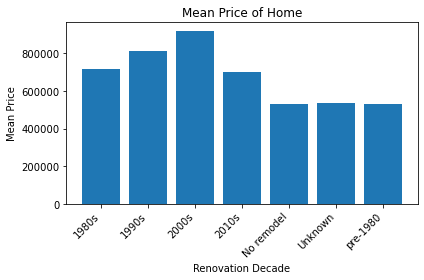

In [135]:
df_yr_renovated = df.groupby('yr_renovated').mean().reset_index()
plt.bar(df_yr_renovated['yr_renovated'], df_yr_renovated['price'])
plt.title('Mean Price of Home')
plt.xlabel('Renovation Decade')
plt.ylabel('Mean Price')
plt.xticks(rotation=45, ha='right');
plt.tight_layout()
plt.savefig('Visualizations/remodeling')

In [136]:
good_school_districts = ['Issaquah', 'Vashon', 'Auburn', 'Enumclaw', 'Renton', 'Lakewood', 'Mercer Island', 'Highline']

In [137]:
schools_df = df[df['Neighborhood'].isin(good_school_districts)]

In [138]:
x = schools_df.groupby('Neighborhood').mean()['price'].index
y = (schools_df.groupby('Neighborhood').mean()['price'].values / 1000000)

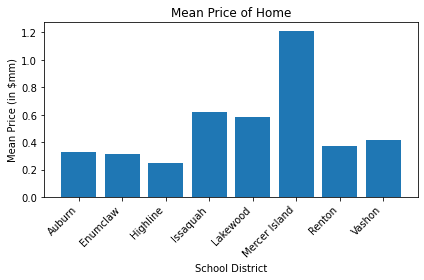

In [139]:
plt.bar(x, y)
plt.title('Mean Price of Home')
plt.xlabel('School District')
plt.ylabel('Mean Price (in $mm)')
plt.xticks(rotation=45, ha='right');
plt.tight_layout()
plt.savefig('Visualizations/school_disctrict')

In [157]:
df_folium = pd.read_csv('data/KC_with_hoods', index_col=0)
relevant_cols = ['lat', 'long']
df_folium = df_folium[relevant_cols]
stakeholder_df = df.copy()

In [158]:
stakeholder_df = pd.concat([stakeholder_df.reset_index(drop=True), df_folium.reset_index(drop=True)], axis=1)

In [159]:
stakeholder_df['Neighborhood'] = stakeholder_df['Neighborhood'].replace(to_replace='Other', value="N/A")

In [160]:
stakeholder_df['Neighborhood'].value_counts()

N/A             3304
Sammamish        886
Kirkland         701
Kent             566
Redmond          496
                ... 
Glendale          12
Valley Green      12
Endolyne          11
Willow Ridge      11
Wyngates          11
Name: Neighborhood, Length: 251, dtype: int64

In [161]:
stakeholder_df = stakeholder_df[stakeholder_df['bedrooms'] == 4]
stakeholder_df = stakeholder_df[stakeholder_df['sqft_living'] >= 4750]

In [162]:
stakeholder_df

price  bedrooms  bathrooms  sqft_living  floors  waterfront  view  \
5      1230000.0         4       4.50         5420     1.0         0.0   0.0   
153    2250000.0         4       3.25         5180     2.0         0.0   3.0   
269    2900000.0         4       3.25         5050     1.5         0.0   2.0   
270    1370000.0         4       4.75         5310     2.0         0.0   0.0   
484    1390000.0         4       3.25         4860     2.5         0.0   0.0   
...          ...       ...        ...          ...     ...         ...   ...   
21294  2350000.0         4       4.25         5010     2.0         0.0   1.0   
21317  2000000.0         4       3.25         5640     2.0         0.0   2.0   
21504  1410000.0         4       4.00         4920     2.0         0.0   0.0   
21514  3000000.0         4       3.75         5090     1.0         0.0   0.0   
21574  1220000.0         4       3.50         4910     1.5         0.0   0.0   

       condition  grade  sqft_basement  ...  sqft_living15 sqft_lot15  \
5              3     11         1530.0  ...           4760     101930   
153            3     12         1640.0  ...           3160       9750   
269            3     11          300.0  ...           3890      20060   
270            4     11            0.0  ...           4180      47443   
484            3      9            0.0  ...           3850     181319   
...          ...    ...            ...  ...            ...        ...   
21294          3     11         1010.0  ...           3820      17064   
21317          3     11          740.0  ...           4920      35033   
21504          3     10          640.0  ...           4920      74052   
21514          3     11          910.0  ...           3030      12752   
21574          3     11         1800.0  ...           4560      11063   

        Neighborhood  Yr_sold  Mo_sold sqft_grade    prediction  \
5                N/A      0.0        5      59620  1.559128e+06   
153         Somerset      1.0        4      62160  2.011946e+06   
269              N/A      1.0        5      55550  2.216128e+06   
270     Cottage Lake      0.0       10      58410  1.583633e+06   
484              N/A      1.0        4      43740  1.136695e+06   
...              ...      ...      ...        ...           ...   
21294  Mercer Island      0.0        7      55110  1.825172e+06   
21317            N/A      1.0        5      62040  1.811572e+06   
21504            N/A      0.0        8      49200  1.253044e+06   
21514          Clyde      1.0        4      55990  2.406979e+06   
21574      Sammamish      0.0        5      54010  1.403270e+06   

            residual      lat     long  
5     -329128.031771  47.6561 -122.005  
153    238054.280329  47.5620 -122.162  
269    683872.343000  47.6312 -122.223  
270   -213633.100941  47.7285 -122.042  
484    253305.034968  47.6179 -122.005  
...              ...      ...      ...  
21294  524828.019725  47.5455 -122.211  
21317  188428.165078  47.5491 -122.104  
21504  156955.607749  47.6575 -122.006  
21514  593021.447024  47.6200 -122.207  
21574 -183269.742988  47.6502 -122.066  

[117 rows x 23 columns]

In [163]:
 def pricecolors(price):
    if  price <= 750000 and price > 0:
        return 'green'
    elif price <= 1500000 and price > 750000:
        return 'blue'
    elif price <= 2250000 and price > 1500000:
        return 'orange'
    else:
        return 'red'

stakeholder_df['color'] = stakeholder_df['price']
stakeholder_df['color'] = stakeholder_df["color"].apply(pricecolors)
stakeholder_df['color'].value_counts()

blue      50
orange    34
red       29
green      4
Name: color, dtype: int64

In [164]:
stakeholder_df

price  bedrooms  bathrooms  sqft_living  floors  waterfront  view  \
5      1230000.0         4       4.50         5420     1.0         0.0   0.0   
153    2250000.0         4       3.25         5180     2.0         0.0   3.0   
269    2900000.0         4       3.25         5050     1.5         0.0   2.0   
270    1370000.0         4       4.75         5310     2.0         0.0   0.0   
484    1390000.0         4       3.25         4860     2.5         0.0   0.0   
...          ...       ...        ...          ...     ...         ...   ...   
21294  2350000.0         4       4.25         5010     2.0         0.0   1.0   
21317  2000000.0         4       3.25         5640     2.0         0.0   2.0   
21504  1410000.0         4       4.00         4920     2.0         0.0   0.0   
21514  3000000.0         4       3.75         5090     1.0         0.0   0.0   
21574  1220000.0         4       3.50         4910     1.5         0.0   0.0   

       condition  grade  sqft_basement  ...  sqft_lot15   Neighborhood  \
5              3     11         1530.0  ...      101930            N/A   
153            3     12         1640.0  ...        9750       Somerset   
269            3     11          300.0  ...       20060            N/A   
270            4     11            0.0  ...       47443   Cottage Lake   
484            3      9            0.0  ...      181319            N/A   
...          ...    ...            ...  ...         ...            ...   
21294          3     11         1010.0  ...       17064  Mercer Island   
21317          3     11          740.0  ...       35033            N/A   
21504          3     10          640.0  ...       74052            N/A   
21514          3     11          910.0  ...       12752          Clyde   
21574          3     11         1800.0  ...       11063      Sammamish   

       Yr_sold  Mo_sold  sqft_grade    prediction       residual      lat  \
5          0.0        5       59620  1.559128e+06 -329128.031771  47.6561   
153        1.0        4       62160  2.011946e+06  238054.280329  47.5620   
269        1.0        5       55550  2.216128e+06  683872.343000  47.6312   
270        0.0       10       58410  1.583633e+06 -213633.100941  47.7285   
484        1.0        4       43740  1.136695e+06  253305.034968  47.6179   
...        ...      ...         ...           ...            ...      ...   
21294      0.0        7       55110  1.825172e+06  524828.019725  47.5455   
21317      1.0        5       62040  1.811572e+06  188428.165078  47.5491   
21504      0.0        8       49200  1.253044e+06  156955.607749  47.6575   
21514      1.0        4       55990  2.406979e+06  593021.447024  47.6200   
21574      0.0        5       54010  1.403270e+06 -183269.742988  47.6502   

          long   color  
5     -122.005    blue  
153   -122.162  orange  
269   -122.223     red  
270   -122.042    blue  
484   -122.005    blue  
...        ...     ...  
21294 -122.211     red  
21317 -122.104  orange  
21504 -122.006    blue  
21514 -122.207     red  
21574 -122.066    blue  

[117 rows x 24 columns]

In [165]:
import folium


lat = 47.47
long = -121.84

base_map = folium.Map([lat,long], zoom_start=15)
base_map

for indice, row in stakeholder_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=('Price: {}, Square Feet: {}, Neighborhood: {} \
        Predicted Price: {}'.format(row['price'], row['sqft_living'], row['Neighborhood'], row['prediction'])),
        icon=folium.map.Icon(color=row['color'])
    ).add_to(base_map)
base_map

In [204]:
# We import the geoJSON file.

# We read the file and print it.
geoJSON_df = gpd.read_file('data/Zip_Codes.geojson')
geoJSON_df

OBJECTID    ZIP ZIPCODE COUNTY   SHAPE_Length    SHAPE_Area  \
0           1  98031   98031    033  117508.211718  2.280129e+08   
1           2  98032   98032    033  166737.664791  4.826754e+08   
2           3  98033   98033    033  101363.840369  2.566747e+08   
3           4  98034   98034    033   98550.452509  2.725072e+08   
4           5  98030   98030    033   94351.264837  2.000954e+08   
..        ...    ...     ...    ...            ...           ...   
199       200  98402   98402    053   30734.178112  2.612224e+07   
200       201  98403   98403    053   23495.038425  2.890938e+07   
201       202  98404   98404    053   61572.154365  2.160645e+08   
202       203  98405   98405    053   50261.100559  1.193118e+08   
203       204  98406   98406    053   74118.972418  1.088373e+08   

                                              geometry  
0    POLYGON ((-122.21842 47.43750, -122.21896 47.4...  
1    MULTIPOLYGON (((-122.24187 47.44122, -122.2436...  
2    POLYGON ((-122.20571 47.65170, -122.20571 47.6...  
3    POLYGON ((-122.17551 47.73706, -122.17551 47.7...  
4    POLYGON ((-122.16746 47.38549, -122.16746 47.3...  
..                                                 ...  
199  POLYGON ((-122.44279 47.26479, -122.44364 47.2...  
200  POLYGON ((-122.44382 47.26617, -122.44384 47.2...  
201  POLYGON ((-122.38900 47.23495, -122.39009 47.2...  
202  POLYGON ((-122.44092 47.23639, -122.44463 47.2...  
203  MULTIPOLYGON (((-122.52125 47.27121, -122.5237...  

[204 rows x 7 columns]

In [223]:
selected_zips = df.groupby('zipcode').mean()['price'].index

In [224]:
new_df = geoJSON_df[geoJSON_df['ZIP'].isin(selected_zips)]

In [225]:
new_df

OBJECTID    ZIP ZIPCODE COUNTY   SHAPE_Length    SHAPE_Area  \
0           1  98031   98031    033  117508.211718  2.280129e+08   
1           2  98032   98032    033  166737.664791  4.826754e+08   
2           3  98033   98033    033  101363.840369  2.566747e+08   
3           4  98034   98034    033   98550.452509  2.725072e+08   
4           5  98030   98030    033   94351.264837  2.000954e+08   
..        ...    ...     ...    ...            ...           ...   
90         91  98177   98177    033   95211.465988  1.596729e+08   
91         92  98178   98178    033   66906.676245  1.353505e+08   
95         96  98198   98198    033  124157.387829  2.108446e+08   
99        100  98199   98199    033   56826.422800  1.145346e+08   
127       128  98188   98188    033   94574.318151  2.187023e+08   

                                              geometry  
0    POLYGON ((-122.21842 47.43750, -122.21896 47.4...  
1    MULTIPOLYGON (((-122.24187 47.44122, -122.2436...  
2    POLYGON ((-122.20571 47.65170, -122.20571 47.6...  
3    POLYGON ((-122.17551 47.73706, -122.17551 47.7...  
4    POLYGON ((-122.16746 47.38549, -122.16746 47.3...  
..                                                 ...  
90   POLYGON ((-122.35904 47.77776, -122.35937 47.7...  
91   POLYGON ((-122.21902 47.50057, -122.21914 47.5...  
95   POLYGON ((-122.31456 47.42438, -122.31567 47.4...  
99   MULTIPOLYGON (((-122.40912 47.67160, -122.4093...  
127  POLYGON ((-122.24187 47.44122, -122.24188 47.4...  

[74 rows x 7 columns]

In [226]:
new_df = new_df.sort_values(by='ZIP')

In [227]:
new_df = new_df.drop_duplicates(subset='ZIPCODE', keep='first')

In [228]:
new_df['ZIP'].value_counts()

98045    1
98106    1
98168    1
98092    1
98166    1
        ..
98003    1
98002    1
98001    1
98126    1
98177    1
Name: ZIP, Length: 70, dtype: int64

In [229]:
new_df

OBJECTID    ZIP ZIPCODE COUNTY   SHAPE_Length    SHAPE_Area  \
42         43  98001   98001    033  156155.466031  5.324255e+08   
41         42  98002   98002    033  102448.491014  2.055688e+08   
40         41  98003   98003    033  120498.920879  3.170769e+08   
39         40  98004   98004    033  108762.980060  2.014501e+08   
38         39  98005   98005    033  116409.338330  2.113641e+08   
..        ...    ...     ...    ...            ...           ...   
90         91  98177   98177    033   95211.465988  1.596729e+08   
91         92  98178   98178    033   66906.676245  1.353505e+08   
127       128  98188   98188    033   94574.318151  2.187023e+08   
95         96  98198   98198    033  124157.387829  2.108446e+08   
99        100  98199   98199    033   56826.422800  1.145346e+08   

                                              geometry  
42   POLYGON ((-122.22992 47.35377, -122.22992 47.3...  
41   POLYGON ((-122.22921 47.35375, -122.22921 47.3...  
40   POLYGON ((-122.30960 47.35795, -122.31323 47.3...  
39   MULTIPOLYGON (((-122.21458 47.65298, -122.2147...  
38   POLYGON ((-122.15876 47.66065, -122.16408 47.6...  
..                                                 ...  
90   POLYGON ((-122.35904 47.77776, -122.35937 47.7...  
91   POLYGON ((-122.21902 47.50057, -122.21914 47.5...  
127  POLYGON ((-122.24187 47.44122, -122.24188 47.4...  
95   POLYGON ((-122.31456 47.42438, -122.31567 47.4...  
99   MULTIPOLYGON (((-122.40912 47.67160, -122.4093...  

[70 rows x 7 columns]

In [230]:
mean_price_values = df.groupby('zipcode').mean()['price'].values

In [231]:
new_df

OBJECTID    ZIP ZIPCODE COUNTY   SHAPE_Length    SHAPE_Area  \
42         43  98001   98001    033  156155.466031  5.324255e+08   
41         42  98002   98002    033  102448.491014  2.055688e+08   
40         41  98003   98003    033  120498.920879  3.170769e+08   
39         40  98004   98004    033  108762.980060  2.014501e+08   
38         39  98005   98005    033  116409.338330  2.113641e+08   
..        ...    ...     ...    ...            ...           ...   
90         91  98177   98177    033   95211.465988  1.596729e+08   
91         92  98178   98178    033   66906.676245  1.353505e+08   
127       128  98188   98188    033   94574.318151  2.187023e+08   
95         96  98198   98198    033  124157.387829  2.108446e+08   
99        100  98199   98199    033   56826.422800  1.145346e+08   

                                              geometry  
42   POLYGON ((-122.22992 47.35377, -122.22992 47.3...  
41   POLYGON ((-122.22921 47.35375, -122.22921 47.3...  
40   POLYGON ((-122.30960 47.35795, -122.31323 47.3...  
39   MULTIPOLYGON (((-122.21458 47.65298, -122.2147...  
38   POLYGON ((-122.15876 47.66065, -122.16408 47.6...  
..                                                 ...  
90   POLYGON ((-122.35904 47.77776, -122.35937 47.7...  
91   POLYGON ((-122.21902 47.50057, -122.21914 47.5...  
127  POLYGON ((-122.24187 47.44122, -122.24188 47.4...  
95   POLYGON ((-122.31456 47.42438, -122.31567 47.4...  
99   MULTIPOLYGON (((-122.40912 47.67160, -122.4093...  

[70 rows x 7 columns]

In [232]:
new_df['price'] = mean_price_values

In [233]:
new_df['price'].apply(lambda x: x/1000000)

42     0.281195
41     0.234284
40     0.294111
39     1.356524
38     0.810290
         ...   
90     0.676419
91     0.310613
127    0.289078
95     0.302897
99     0.792188
Name: price, Length: 70, dtype: float64

In [234]:
lat = 47.47
long = -121.84

base_map = folium.Map([lat,long], zoom_start=15)
base_map


folium.Choropleth(
    geo_data=new_df,
    data=new_df,
    columns=['ZIP','price'],
    key_on='feature.properties.ZIP',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price per home').add_to(base_map)
base_map